In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCarContinuous-v0")
env.observation_space.sample()

[2017-04-09 23:45:04,937] Making new env: MountainCarContinuous-v0


array([-0.21213569,  0.03012651])

In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurized represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [4]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [5]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.action = tf.placeholder(dtype=tf.float32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer())
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer())
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)
            self.action = self.normal_dist._sample_n(1)
            self.action = tf.clip_by_value(self.action, env.action_space.low[0], env.action_space.high[0])

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.action) * self.target
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.action, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [6]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer())

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [7]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        # Reset the environment
        state = env.reset()

        # Generate an episode
        # I = 1
        for t in itertools.count():
            action = estimator_policy.predict(state)
            next_state, reward, done, _ = env.step(action)

            td_target = reward + discount_factor*estimator_value.predict(next_state)
            td_error = td_target - estimator_value.predict(state)
            
            estimator_value_loss = estimator_value.update(state, td_target)
            # TODO: Have to multiply learning rate to I:
            estimator_policy_loss = estimator_policy.update(state, td_error, action)
            # I *= discount_factor

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if done:
                break
            state = next_state

        # Print out which episode we're on, useful for debugging.
        print("\rStep {} @ Episode {}/{}".format(
            t, i_episode + 1, num_episodes))
    
    return stats

In [8]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is happening there.
    stats = actor_critic(env, policy_estimator, value_estimator, 50, discount_factor=0.95)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


[2017-04-09 23:45:06,726] From <ipython-input-8-1d4b089abaab>:8: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Step 998 @ Episode 1/50
Step 552 @ Episode 2/50
Step 311 @ Episode 3/50
Step 248 @ Episode 4/50
Step 295 @ Episode 5/50
Step 265 @ Episode 6/50
Step 279 @ Episode 7/50
Step 297 @ Episode 8/50
Step 238 @ Episode 9/50
Step 217 @ Episode 10/50
Step 411 @ Episode 11/50
Step 390 @ Episode 12/50
Step 295 @ Episode 13/50
Step 373 @ Episode 14/50
Step 236 @ Episode 15/50
Step 241 @ Episode 16/50
Step 136 @ Episode 17/50
Step 245 @ Episode 18/50
Step 191 @ Episode 19/50
Step 289 @ Episode 20/50
Step 137 @ Episode 21/50
Step 265 @ Episode 22/50
Step 173 @ Episode 23/50
Step 229 @ Episode 24/50
Step 143 @ Episode 25/50
Step 145 @ Episode 26/50
Step 239 @ Episode 27/50
Step 115 @ Episode 28/50
Step 159 @ Episode 29/50
Step 256 @ Episode 30/50
Step 250 @ Episode 31/50
Step 303 @ Episode 32/50
Step 216 @ Episode 33/50
Step 152 @ Episode 34/50
Step 260 @ Episode 35/50
Step 282 @ Episode 36/50
Step 147 @ Episode 37/50
Step 256 @ Episode 38/50
Step 179 @ Episode 39/50
Step 143 @ Episode 40/50
Step 150 

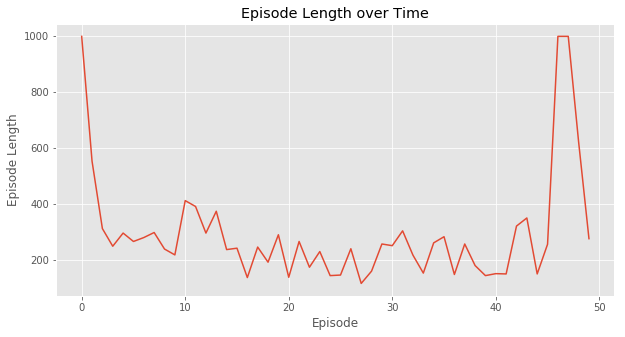

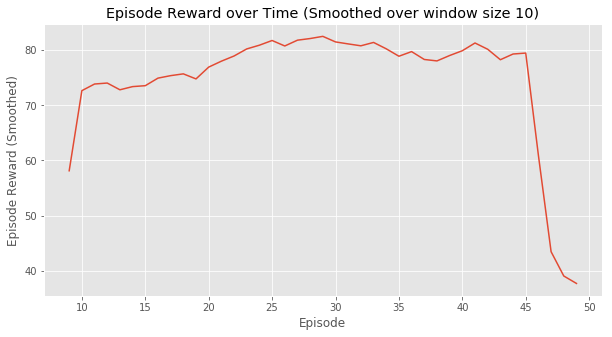

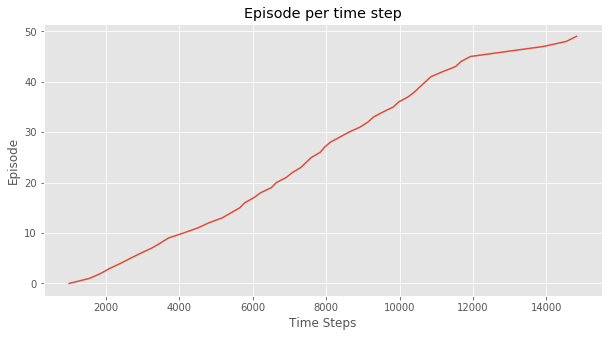

(<matplotlib.figure.Figure at 0x1137a3a90>,
 <matplotlib.figure.Figure at 0x113802ac8>)

In [9]:
plotting.plot_episode_stats(stats, smoothing_window=10)